In [669]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as spicystats
import sys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, roc_curve

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
import statsmodels.api as sm


from sklearn.preprocessing import StandardScaler

sys.path.insert(0, '../src')
sys.path.insert(0, '../data')


import chess

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [670]:
# Read in chess dataset and sample it. Drop columns containing immaterial data.
chess_games = pd.read_csv("../data/games.csv")
chess_games.drop(['rated', 'id', 'created_at', 'last_move_at', 'increment_code', 'white_id', 'black_id', 'opening_eco'], axis=1, inplace=True)
chess_games.sample(10)

,turns,victory_status,winner,white_rating,black_rating,moves,opening_name,opening_ply
18946,64,resign,black,1857,2084,e4 c5 Bc4 e6 Nf3 d5 exd5 exd5 Qe2+ Be7 Bb5+ Nc...,Sicilian Defense: Bowdler Attack,3
14367,72,resign,black,1330,1257,e4 c5 Nf3 Nc6 d4 e6 d5 exd5 exd5 Qe7+ Qe2 Nd4 ...,Sicilian Defense: Franco-Sicilian Variation,6
15207,68,resign,black,1399,1554,e4 e5 Nf3 Nc6 Bb5 d6 O-O a6 Bxc6+ bxc6 d4 Bg4 ...,Ruy Lopez: Steinitz Defense,6
14986,28,mate,black,1580,1706,d4 e6 c4 c6 Nc3 d5 e3 Nf6 Nf3 Bb4 a3 Ba5 b4 Bc...,Semi-Slav Defense: Main Line,9
18331,45,mate,white,1594,1545,e4 c6 d4 d5 Nc3 dxe4 Nxe4 Nd7 Qe2 e6 Nf3 Ngf6 ...,Caro-Kann Defense: Karpov Variation,8
4508,35,resign,white,1882,1828,d4 d5 Bg5 h6 Bh4 Bf5 e3 c6 Bd3 Bxd3 Qxd3 Nf6 N...,Queen's Pawn Game: Levitsky Attack,3
6822,23,mate,white,1392,1284,e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5 exd5 Na5 d6 Nxc4 ...,Italian Game: Two Knights Defense | Polerio D...,10
8445,159,draw,draw,1455,1510,e4 e5 Qh5 Nc6 Bc4 Qe7 Nh3 h6 d3 Nd4 Na3 c6 c3 ...,King's Pawn Game: Wayward Queen Attack,3
16353,28,resign,black,1400,1395,Nf3 d6 b3 Bg4 Bb2 c5 e3 Bh5 d3 Nc6 Nbd2 g6 Bxh...,Zukertort Opening: Pirc Invitation,2
15423,114,mate,black,1483,1737,e4 d5 exd5 Qxd5 Nc3 Qd8 d3 Nf6 Nf3 Bg4 Be2 e6 ...,Scandinavian Defense: Mieses-Kotroc Variation,4


In [671]:
victory_status = chess_games['victory_status'].value_counts()
victory_status

resign       11147
mate          6325
outoftime     1680
draw           906
Name: victory_status, dtype: int64

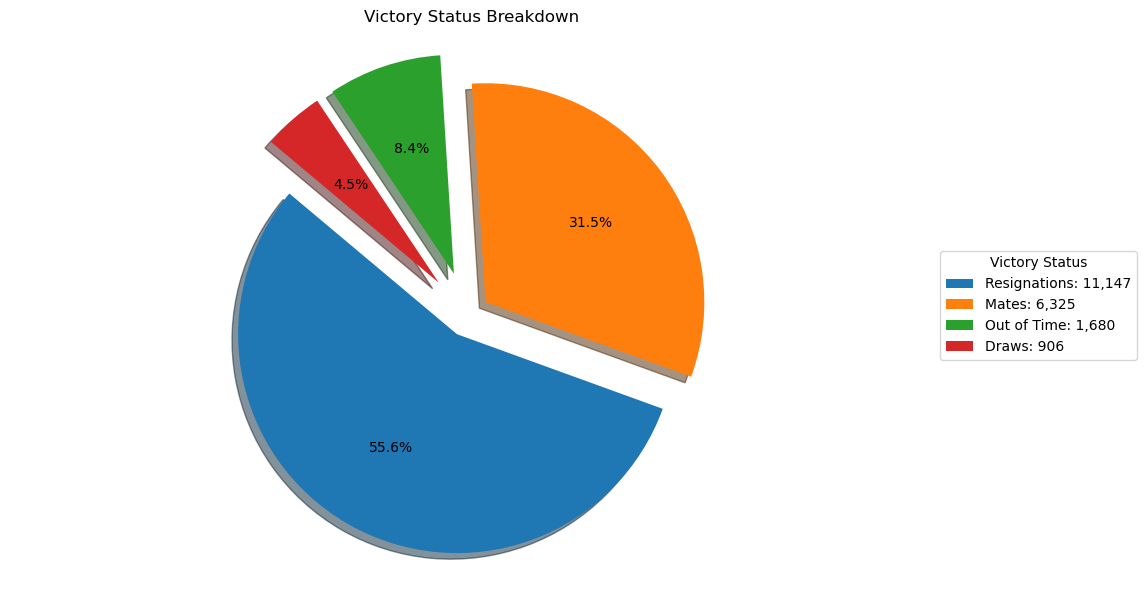

In [672]:
# Grab and count the chess victory status, broken down by category. Make pie chart to depict the delineations.

def chess_victories(chess_df):
     victory_status = chess_df['victory_status'].value_counts()

     fig, ax = plt.subplots(figsize = (10,6))

     sizes = victory_status.values
     labels = ['Resignations: 11,147', 'Mates: 6,325', 'Out of Time: 1,680', 'Draws: 906']
     explode = (0.1, 0.1, 0.2, 0.2)
     c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
     plt.pie(sizes, explode=explode, colors=c, 
        autopct='%1.1f%%', shadow=True, startangle=140)
     ax.legend( labels, title="Victory Status",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
     ax.set_title("Victory Status Breakdown")
     plt.tight_layout()
     plt.axis('equal')
     plt.show()
     return victory_status
victories_breakdown = chess_victories(chess_games)



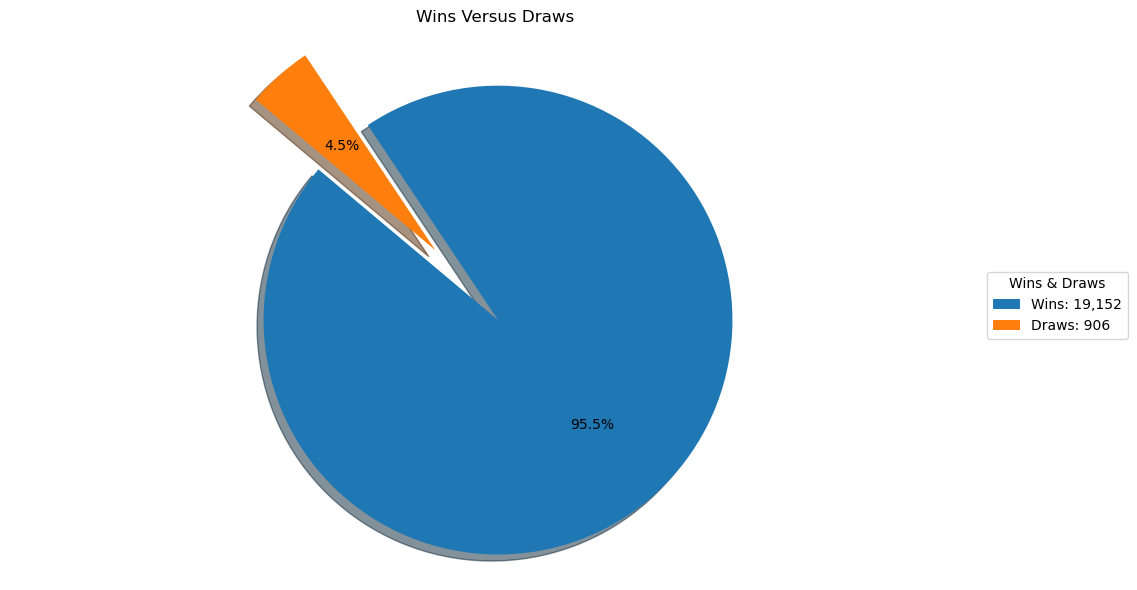

('95.48309901286271', '4.516900987137302')

In [673]:
# Look at games won, by mate, out of time, and resignation, and compare to draws. Make pie charts for both delineations. 

def wins_versus_losses(chess_df):
    game_status = chess_games['victory_status'].value_counts('draw')
    game_status_percent = game_status * 100
    victories_percent = str(sum(game_status_percent.iloc[:3]))
    draws_percent = str(sum(game_status_percent.iloc[-1:]))
    game_wins = sum(game_status.iloc[:3])
    game_draws = sum(game_status.iloc[-1:])
    
    fig, ax = plt.subplots(figsize = (10,6))

    sizes = victories_percent, draws_percent
    labels = ['Wins: 19,152', 'Draws: 906']
    explode = (0.2, 0.2)
    c = ['#1f77b4', '#ff7f0e']
    plt.pie(sizes, explode=explode, colors=c, 
        autopct='%1.1f%%', shadow=True, startangle=140)
    ax.legend(labels, title="Wins & Draws",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title("Wins Versus Draws")
    plt.tight_layout()
    plt.axis('equal')
    plt.show()
    return victories_percent, draws_percent
wins_versus_losses(chess_games)

In [674]:
# Look at stronger white players, greater than 100 ELO, and map winning categories [mate, out of time, and resign] to 1 and draw category to 0.
def chess_differentials_white(chess_df):
    chess_df = chess_df.copy()
    chess_df['Rating Differential White'] = (chess_df['white_rating'] - chess_df['black_rating'])
    white_greater_100 = chess_df[chess_df['Rating Differential White'] > 100]
    
    
    def victory_status(s):
        if s == 'draw':
            return 0

        else:
            return 1
    white_greater_100['victory_status'] = white_greater_100['victory_status'].apply(victory_status)
    
  
 
    return white_greater_100

chess_outcomes_white = chess_differentials_white(chess_games)
chess_outcomes_white


C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\2228763733.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_greater_100['victory_status'] = white_greater_100['victory_status'].apply(victory_status)


,turns,victory_status,winner,white_rating,black_rating,moves,opening_name,opening_ply,Rating Differential White
0,13,1,white,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,Slav Defense: Exchange Variation,5,309
5,5,0,draw,1250,1002,e4 c5 Nf3 Qa5 a3,Sicilian Defense: Mongoose Variation,4,248
9,119,1,white,1381,1209,e4 d5 exd5 Qxd5 Nc3 Qe5+ Be2 Na6 d4 Qf5 Bxa6 b...,Scandinavian Defense: Mieses-Kotroc Variation,4,172
10,39,1,white,1381,1272,e3 e6 d4 d6 Bd3 c6 Nf3 Be7 Nc3 Nf6 Bd2 Bd7 Qe2...,Van't Kruijs Opening,1,109
19,25,1,white,1500,1094,d4 d5 h3 Nc6 Nf3 Nf6 Bg5 h6 Bxf6 exf6 e3 Bb4+ ...,Queen's Pawn Game,2,406
...,...,...,...,...,...,...,...,...,...
20042,53,1,white,1759,1265,e4 d6 d4 Nf6 Nc3 Nbd7 f4 e5 Nf3 Be7 dxe5 dxe5 ...,Lion Defense: Anti-Philidor | Lion's Cave,8,494
20044,37,1,white,1523,1256,e4 e6 d4 d5 e5 Nc6 Nf3 f6 Bb5 Bd7 O-O Nge7 exf...,French Defense: Advance Variation #3,5,267
20050,9,1,white,1243,1142,c4 e5 d4 exd4 Qxd4 Nf6 Bg5 Be7 e4,English Opening: King's English Variation,2,101
20053,24,1,white,1691,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,Dutch Defense,2,471


In [675]:
# Look at stronger black players, greater than 100 ELO, and map winning categories [mate, out of time, and resign] to 1 and draw category to 0.
def chess_differentials_black(chess_df):
    chess_df = chess_df.copy()
    chess_df['Rating Differential Black'] = (chess_df['black_rating'] - chess_df['white_rating'])
    black_greater_100 = (chess_df[chess_df['Rating Differential Black'] > 100])

    def victory_status(s):
        if s == 'draw':
            return 0

        else:
            return 1
    black_greater_100['victory_status'] = black_greater_100['victory_status'].apply(victory_status)
  
    return black_greater_100
chess_outcomes_black = chess_differentials_black(chess_games)
chess_outcomes_black

C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\3598573172.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_greater_100['victory_status'] = black_greater_100['victory_status'].apply(victory_status)


,turns,victory_status,winner,white_rating,black_rating,moves,opening_name,opening_ply,Rating Differential Black
7,9,1,black,1413,2108,e4 Nc6 d4 e5 d5 Nce7 c3 Ng6 b4,Nimzowitsch Defense: Kennedy Variation | Link...,5,695
11,38,1,black,1381,1867,e4 e6 d4 d5 e5 c5 c3 Nc6 Nf3 Qb6 Be3 Qxb2 Nbd2...,French Defense: Advance Variation | Paulsen A...,9,486
12,60,1,black,1381,1936,e4 e6 Nf3 d5 exd5 exd5 Qe2+ Be7 Nc3 Nf6 d4 O-O...,French Defense: Knight Variation,3,555
13,31,1,black,1381,1607,e4 e6 Qh5 g6 Qe5 Nf6 d4 d6 Qb5+ Bd7 Qxb7 Bc6 Q...,French Defense #2,2,226
18,101,1,black,1094,1300,e4 e5 Nf3 d6 Bc4 Be6 d3 Bxc4 dxc4 c5 O-O h6 Nc...,Philidor Defense #3,5,206
...,...,...,...,...,...,...,...,...,...
20036,43,1,white,1247,1436,c4 e5 Nc3 Bc5 e3 Nc6 a3 Nf6 b4 Bd6 Nf3 a6 c5 B...,English Opening: King's English Variation | R...,3,189
20038,36,1,black,1247,1359,c4 e5 Nc3 Bb4 Nd5 a5 Nf3 Nc6 a3 Bc5 d3 Nf6 Bd2...,English Opening: King's English Variation | K...,4,112
20040,87,1,black,1261,1461,c4 Nf6 d4 e6 Nc3 Bb4 Bd2 c5 Be3 b6 Nf3 Bb7 g3 ...,Nimzo-Indian Defense,6,200
20041,58,1,black,1263,1770,d4 d5 Bf4 Bf5 e3 Nf6 c3 e6 Nf3 Nh5 Bg5 f6 Bh4 ...,Queen's Pawn Game: Mason Attack,3,507


In [680]:
# Perform nonlinear Spearman correlation to see potential correlations between rating differentals, fow hwite and black respectively, and their victory status.
def chess_correlations_spearman(white, black):
    white_correlation_spearman = white['Rating Differential White'].corr(white['victory_status'], method ='spearman')

    black_correlation_spearman = black['Rating Differential Black'].corr(black['victory_status'], method ='spearman')

    return white_correlation_spearman, black_correlation_spearman
chess_correlations = chess_correlations_spearman(chess_differentials_white(chess_games), chess_differentials_black(chess_games))
chess_correlations

C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\2228763733.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_greater_100['victory_status'] = white_greater_100['victory_status'].apply(victory_status)
C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\3598573172.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_greater_100['victory_status'] = black_greater_100['victory_status'].apply(victory_status)


(0.005051227522468715, 0.05171853990117713)

In [ ]:
# Null Hypothesis: The rating differential between black and white has no significant impact on which player wins the game.
# Alternate Hypothesis: The rating differential between black and white has a significant impact on which player wins the game.

In [ ]:
# Look at potential spearman and pearson correlations regarding player rating differential and victory status.
def rating_differential_hypothesis(chess_df):
    spicystats.ttest_ind(ctr_signed_in['CTR'], ctr_not_signed_in['CTR'], equal_var = False)
    spicystats.ttest_ind(ctr_signed_in['CTR'], ctr_not_signed_in['CTR'], equal_var = False)
    return white_greater_100
draws_gone = rating_differential_hypothesis(chess_games)
draws_gone

NameError: name 'ctr_signed_in' is not defined